In [101]:
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image
import easyocr
from rapidfuzz.distance import JaroWinkler
import supervision as sv
from tqdm import tqdm
from Levenshtein import distance as levenshtein_distance
from paddleocr import PaddleOCR

In [58]:
upscale_model = cv2.dnn_superres.DnnSuperResImpl_create()
upscale_model.readModel('/Users/shravanp/Coding/Robotics/AIScouter/src/models/ESPCN_x4.pb')
upscale_model.setModel('espcn', 4)

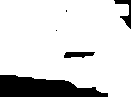

In [33]:
image = cv2.imread('/Users/shravanp/Coding/Robotics/AIScouter/runs/detect/predict/crops/Robot/test.jpg')
height, width, _ = image.shape

# Extract the bottom half of the image
bottom_half = image[height // 2:height, :]
gray = cv2.cvtColor(bottom_half, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
kernal = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
dilate = cv2.dilate(thresh, kernal, iterations=1)

Image.fromarray(np.array(dilate))

In [17]:
import numpy as np
from scipy import fft
from skimage import io, exposure, img_as_ubyte, img_as_float
from tqdm import trange
import matplotlib.pyplot as plt
import argparse
import os


def firstOrderDerivative(n, k=1):
    return np.eye(n) * (-1) + np.eye(n, k=k)


def toeplitizMatrix(n, row):
    vecDD = np.zeros(n)
    vecDD[0] = 4
    vecDD[1] = -1
    vecDD[row] = -1
    vecDD[-1] = -1
    vecDD[-row] = -1
    return vecDD


def vectorize(matrix):
    return matrix.T.ravel()


def reshape(vector, row, col):
    return vector.reshape((row, col), order='F')


class LIME:
    def __init__(self, iterations=10, alpha=2, rho=2, gamma=0.7, strategy=2, *args, **kwargs):
        self.iterations = iterations
        self.alpha = alpha
        self.rho = rho
        self.gamma = gamma
        self.strategy = strategy

    def load(self, img):
        if isinstance(img, np.ndarray):
            # Convert the image to float if it's not already
            if img.dtype != np.float32 and img.dtype != np.float64:
                img = img_as_float(img)
            self.L = img
        else:
            raise ValueError("Input must be a numpy.ndarray")

        self.row = self.L.shape[0]
        self.col = self.L.shape[1]

        # Handle grayscale images (2D arrays) separately
        if self.L.ndim == 2:
            self.T_hat = self.L
        else:
            self.T_hat = np.max(self.L, axis=2)

        self.dv = firstOrderDerivative(self.row)
        self.dh = firstOrderDerivative(self.col, -1)
        self.vecDD = toeplitizMatrix(self.row * self.col, self.row)
        self.W = self.weightingStrategy()

    def weightingStrategy(self):
        if self.strategy == 2:
            dTv = self.dv @ self.T_hat
            dTh = self.T_hat @ self.dh
            Wv = 1 / (np.abs(dTv) + 1)
            Wh = 1 / (np.abs(dTh) + 1)
            return np.vstack([Wv, Wh])
        else:
            return np.ones((self.row * 2, self.col))

    def __T_subproblem(self, G, Z, u):
        X = G - Z / u
        Xv = X[:self.row, :]
        Xh = X[self.row:, :]
        temp = self.dv @ Xv + Xh @ self.dh
        numerator = fft.fft(vectorize(2 * self.T_hat + u * temp))
        denominator = fft.fft(self.vecDD * u) + 2
        T = fft.ifft(numerator / denominator)
        T = np.real(reshape(T, self.row, self.col))
        return exposure.rescale_intensity(T, (0, 1), (0.001, 1))

    def __G_subproblem(self, T, Z, u, W):
        dT = self.__derivative(T)
        epsilon = self.alpha * W / u
        X = dT + Z / u
        return np.sign(X) * np.maximum(np.abs(X) - epsilon, 0)

    def __Z_subproblem(self, T, G, Z, u):
        dT = self.__derivative(T)
        return Z + u * (dT - G)

    def __u_subproblem(self, u):
        return u * self.rho

    def __derivative(self, matrix):
        v = self.dv @ matrix
        h = matrix @ self.dh
        return np.vstack([v, h])

    def illumMap(self):
        T = np.zeros((self.row, self.col))
        G = np.zeros((self.row * 2, self.col))
        Z = np.zeros((self.row * 2, self.col))
        u = 1

        for _ in trange(0, self.iterations):
            T = self.__T_subproblem(G, Z, u)
            G = self.__G_subproblem(T, Z, u, self.W)
            Z = self.__Z_subproblem(T, G, Z, u)
            u = self.__u_subproblem(u)

        return T ** self.gamma

    def enhance(self):
        self.T = self.illumMap()

        if self.L.ndim == 2:  # Grayscale image
            self.R = self.L / self.T  # Direct division
        else:  # Color image
            self.R = self.L / np.repeat(self.T[:, :, np.newaxis], 3, axis=2)

        self.R = exposure.rescale_intensity(self.R, (0, 1))
        self.R = img_as_ubyte(self.R)
        return self.R

100%|██████████| 50/50 [00:05<00:00,  9.40it/s]


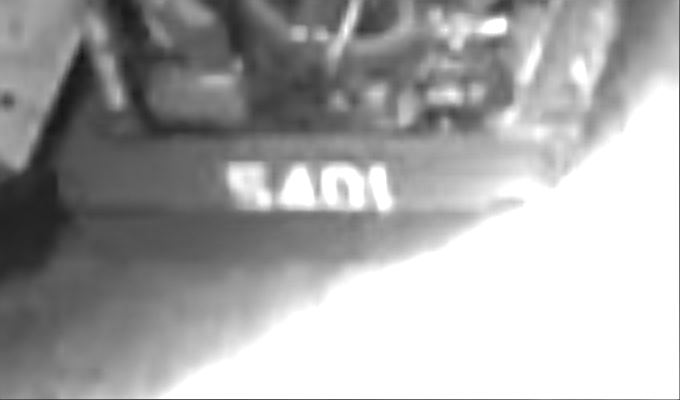

In [102]:
lime = LIME(iterations=50, alpha=1, rho=1.5, gamma=0.5, strategy=1)
image = cv2.imread('/Users/shravanp/Coding/Robotics/AIScouter/runs/detect/predict/crops/Robot/test4.jpg')
height, width, _ = image.shape

# Extract the bottom half of the image
bottom_half = image[height // 2:height, :]
upscaled_bottom_half = upscale_model.upsample(bottom_half)
gray = cv2.cvtColor(upscaled_bottom_half, cv2.COLOR_BGR2GRAY)
# Load the image (PNG or JPG)

lime.load(gray)  # You can use .png or .jpg here

# Perform enhancement
enhanced_image = lime.enhance()
Image.fromarray(np.array(enhanced_image))

In [107]:
reader = easyocr.Reader(['en'], gpu=True)
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024-08-18 19:07:10,641] [ WARNING] easyocr.py:80 - Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[2024/08/18 19:07:15] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/shravanp/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/shravanp/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_t

In [108]:
result = ocr.ocr(np.array(enhanced_image), cls=True)
result2 = reader.readtext(enhanced_image)

print(result)
print(result2)

[2024/08/18 19:07:20] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.437427282333374
[2024/08/18 19:07:20] ppocr DEBUG: cls num  : 1, elapsed : 0.03484487533569336
[2024/08/18 19:07:20] ppocr DEBUG: rec_res num  : 1, elapsed : 0.17130327224731445
[[[[[224.0, 157.0], [395.0, 160.0], [394.0, 215.0], [223.0, 212.0]], ('SAnI', 0.8169246315956116)]]]
[([[221, 155], [405, 155], [405, 217], [221, 217]], 'Radi', 0.17136524617671967)]


In [100]:
levenshtein_distance("Radi", "5401")

4

In [67]:
import smtplib
from email.mime.text import MIMEText

# Your email credentials
sender_email = "shravanapps44@gmail.com"
receiver_email = "6092127855@vtext.com"  # For Verizon SMS-to-email
password = "pxyzvfpyghrduhmu"

message = MIMEText("Process Done")
message['Subject'] = "Notification"
message['From'] = sender_email
message['To'] = receiver_email

with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
    server.login(sender_email, password)
    server.sendmail(sender_email, receiver_email, message.as_string())

print("Email sent successfully")

Email sent successfully


In [111]:
for i in range(1,1000):
    lime = LIME(iterations=1, alpha=1, rho=1.5, gamma=0.5, strategy=i)